In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d as mpl3
from matplotlib.animation import FuncAnimation
NUM_JOINTS = 20
in_data = pd.read_csv("C:\\Users\\96ahi\\PycharmProjects\\SkeletalDataVisualize\\data\\Data\\2038363491\\s-S1_20170503183854211.txt",header=None, sep=";")

# Get indices of each frame. Skip splitting on the first frame ( frame 0 )
split_idcs = list(range(0,len(in_data),NUM_JOINTS))[1:]

in_frames = np.reshape(in_data.values[:,1:],(-1,20,3)).astype(np.float32)

# Coordinate mapping for display
cm = {0:2,1:0,2:1}

In [2]:
spine = np.array([0,1,10,11])
l_arm = np.array([1,3,5,7,9])
l_leg = np.array([11,13,15,17,19])
r_arm = np.array([1,2,4,6,8])
r_leg = np.array([11,12,14,16,18])

In [3]:
def update_func(frame_num,data,plot,mp):
    global spine,l_arm,l_leg,r_arm,r_leg
    plot[0].set_data(data[frame_num,:,mp[0]],data[frame_num,:,mp[1]])
    plot[0].set_3d_properties(data[frame_num,:,mp[2]])
    
    plot[1].set_data(data[frame_num,l_arm,mp[0]],data[frame_num,l_arm,mp[1]])
    plot[1].set_3d_properties(data[frame_num,l_arm,mp[2]])
    
    plot[2].set_data(data[frame_num,r_arm,mp[0]],data[frame_num,r_arm,mp[1]])
    plot[2].set_3d_properties(data[frame_num,r_arm,mp[2]])
    
    plot[3].set_data(data[frame_num,l_leg,mp[0]],data[frame_num,l_leg,mp[1]])
    plot[3].set_3d_properties(data[frame_num,l_leg,mp[2]])
    
    plot[4].set_data(data[frame_num,r_leg,mp[0]],data[frame_num,r_leg,mp[1]])
    plot[4].set_3d_properties(data[frame_num,r_leg,mp[2]])
    
    plot[5].set_data(data[frame_num,spine,mp[0]],data[frame_num,spine,mp[1]])
    plot[5].set_3d_properties(data[frame_num,spine,mp[2]])
    #plot.set_data(data[frame_num,:,mp[0]],data[frame_num,:,mp[1]])
    #plot.set_3d_properties(data[frame_num,:,mp[2]])
    return plot

In [4]:
axis_max = in_frames.max(axis=(0,1))
axis_min = in_frames.min(axis=(0,1))
pad = 0.5

<IPython.core.display.Javascript object>


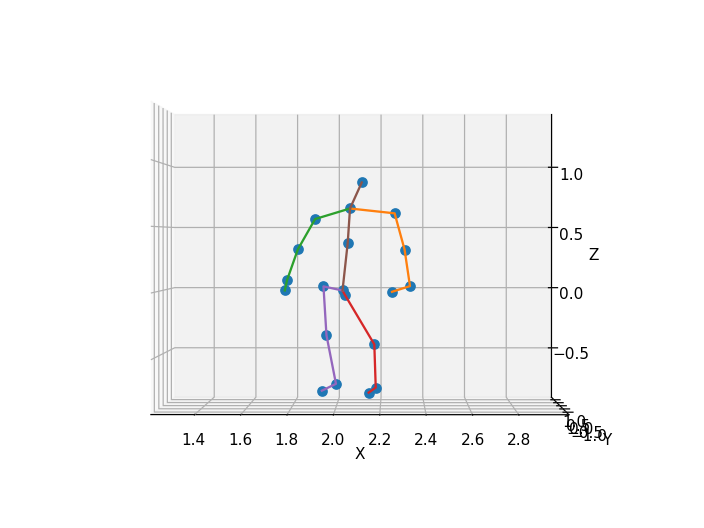

In [6]:
fig = plt.figure()

ax = mpl3.Axes3D(fig)
ax.set_xlim(axis_min[cm[0]]-pad,axis_max[cm[0]]+pad)
ax.set_ylim(axis_min[cm[1]]-pad,axis_max[cm[1]]+pad)
ax.set_zlim(axis_min[cm[2]],axis_max[cm[2]]+pad)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

joint_p, = ax.plot(in_frames[0,:,cm[0]],in_frames[0,:,cm[1]],in_frames[0,:,cm[2]],linestyle="",marker="o")
larm_p, = ax.plot(in_frames[0,l_arm,cm[0]],in_frames[0,l_arm,cm[1]],in_frames[0,l_arm,cm[2]])
rarm_p, = ax.plot(in_frames[0,r_arm,cm[0]],in_frames[0,r_arm,cm[1]],in_frames[0,r_arm,cm[2]])
lleg_p, = ax.plot(in_frames[0,l_leg,cm[0]],in_frames[0,l_leg,cm[1]],in_frames[0,l_leg,cm[2]])
rleg_p, = ax.plot(in_frames[0,r_leg,cm[0]],in_frames[0,r_leg,cm[1]],in_frames[0,r_leg,cm[2]])
spine_p, = ax.plot(in_frames[0,spine,cm[0]],in_frames[0,spine,cm[1]],in_frames[0,spine,cm[2]])


anim = FuncAnimation(fig,update_func,frames=in_frames.shape[0],fargs=(in_frames,(joint_p,larm_p,rarm_p,lleg_p,rleg_p,spine_p),cm),interval=50,blit=True)

plt.show()